## Baseline - RandomSampling

/home/iai/heo/recipe1_total_new_MinMaxscaler/pytorch_module
Advance model Early stopping
Basic model Early stopping
Random State가  1  일 때  Baseline model:  0.7117786790661426
Split_ratio:  0.2 이고 Random State가  1  일 때  model split ratio 0.2:  0.7129816862349427
Random State가  1  일 때  Advance model:  0.7434110910670875
Advance model Early stopping
Basic model Early stopping
Random State가  2  일 때  Baseline model:  0.7222601878308449
Split_ratio:  0.2 이고 Random State가  2  일 때  model split ratio 0.2:  0.7264545618829168
Random State가  2  일 때  Advance model:  0.7436141885088061
Advance model Early stopping
Basic model Early stopping
Random State가  3  일 때  Baseline model:  0.7342754966548315
Split_ratio:  0.2 이고 Random State가  3  일 때  model split ratio 0.2:  0.7372500724427702
Random State가  3  일 때  Advance model:  0.7394576193585036
Advance model Early stopping
Basic model Early stopping
Random State가  4  일 때  Baseline model:  0.715613091933907
Split_ratio:  0.2 이고 Random State가  4  일 때  mo

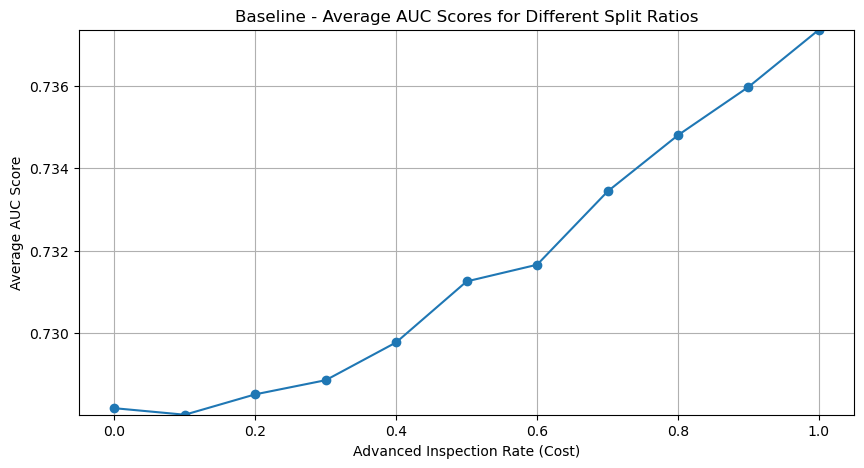

In [1]:
## 필요한 라이브러리 불러오기

import torch 
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
import warnings 
warnings.filterwarnings('ignore') 
from scipy import io
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import random 
import os 
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset,DataLoader

# 설치된 모듈 경로로 이동하기

%cd /home/iai/heo/recipe1_total_new_MinMaxscaler/pytorch_module

# 모듈 함수 불러오기

from split_and_predict_randomsampling import split_and_predict
from seed_everything import seed_everything
from train_teacher import train_teacher
from train_kdstudent import train_kdstudent
from train_student import train_student
from test_predict import test_predict

#---------------------------------------------------------------------------------------------------------------------------------------------------------------

# Define the range of random states

random_states = range(1, 31)

# Advance inspection ratio 정의
split_ratios = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

auc_scores_Baseline_randomsampling = np.zeros((len(random_states), len(split_ratios)))


# 데이터 업로드

df = pd.read_csv('/home/iai/heo/recipe2/activeinspection_recipe2.csv')
X=df.iloc[:,3:-1].values
Y=df.iloc[:,-1].values
data_X = pd.DataFrame(X)
data_Y = pd.DataFrame(Y)
data_Y = data_Y.rename(columns={0: '0.1'})
# 난수 고정

seed_everything(42)

# advance model(teacher model)에 사용될 feature

teacher_model_features=len(list(data_X.columns)) # 88

# advance model(teacher model) 정의하기

class Teacher(nn.Module):
    def __init__(self):
        super(Teacher, self).__init__()
        self.classifier=nn.Sequential(
            nn.Linear(in_features=teacher_model_features,out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10,out_features=2)
        )
    def forward(self, x):
        output=self.classifier(x)
        return output


# student model(basic model)에서 사용될 feature

test_stage_features=[0,1,2,3,4,5,6,7]
student_model_features=len(test_stage_features)
class Student(nn.Module):
    def __init__(self):
        super(Student, self).__init__()
        self.classifier=nn.Sequential(
            nn.Linear(in_features=8,out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10,out_features=2),
        )
    def forward(self, x):
        output=self.classifier(x)
        return output  


# 하이퍼파라미터 세팅

learning_rate = 0.01
num_epochs = 200


# loss function - crossentropy()함수

a=986/(244020+986)
b=244020/(244020+986)
weights=[a,b]
weights=torch.FloatTensor(weights)

criterion = nn.CrossEntropyLoss(weights)

# 30회 반복시 preliminary experiment( AUC 평균, 표준편차 )의 결과를 계산하기 위한 리스트

auc_score30_split_Baseline=[]
auc_score30_split_Baseline_0_2=[]
auc_score30_split_ad_BL=[]


#-------------------------------------------------------------------------------------------------------------------------------------------------
# 학습이 다음 순으로 진행됩니다.

# 1.기본 설정

#여러 다양한 초기 랜덤 상태에 대해 실험을 진행합니다. 이 때, random_states 값은 1부터 30까지 설정됩니다.

# 2.데이터 처리

# 데이터를 학습, 검증, 테스트 데이터로 분리합니다.
# 데이터를 정규화합니다.
# 데이터를 PyTorch의 Tensor로 변환하고 DataLoader를 설정합니다.

# 3.선생님 모델 학습 (Advance 모델)

# 이 모델은 주어진 데이터로 학습을 진행하며, 각 에포크마다 학습 및 검증 손실을 계산합니다.
# 조기 종료(early stopping) 메커니즘이 적용됩니다. 연속적으로 모델 성능 향상이 없을 경우 학습이 조기 종료될 수 있습니다.

# 4.학생 모델 학습 (기본 모델)

# 학생 모델도 같은 방식으로 학습되지만, 선생님 모델과는 다른 입력 특성을 사용할 수 있습니다.
# 학생 모델도 조기 종료 메커니즘을 사용합니다.

# 5. Test data의 예측값 생성

# 테스트 데이터를 사용하여 학생 모델의 예측값을 생성합니다.

# 6.분할 데이터의 성능 평가

# 분할된 각 데이터 집합에 대해 선생님 모델의 성능 (AUC)을 평가합니다.



random_states=range(1, 31)

# 30회 반복 실험
for i,random_state in enumerate(random_states):

    # 데이터 분할
    
    train_X, test_X, train_y, test_y = train_test_split(data_X, data_Y, test_size=0.5, random_state=random_state, shuffle=True, stratify=data_Y)
    train_X, val_X, train_y, val_y=train_test_split(train_X,train_y,test_size=1/5, random_state=random_state,shuffle=True, stratify=train_y)
    
    # 데이터 정규화
    
    scaler = MinMaxScaler()
    train_X_scaled = scaler.fit_transform(train_X)
    val_X_scaled=scaler.transform(val_X)
    test_X_scaled = scaler.transform(test_X)
    
    # 데이터들을 파이토치 텐서로 변환 

    train_X_tensor=torch.tensor(train_X_scaled,dtype=torch.float32)
    train_y_tensor=torch.tensor(np.array(train_y),dtype=torch.long)
    val_X_tensor=torch.tensor(val_X_scaled, dtype=torch.float32)
    val_y_tensor=torch.tensor(np.array(val_y),dtype=torch.long)
    test_X_tensor=torch.tensor(test_X_scaled,dtype=torch.float32)
    test_y_tensor=torch.tensor(np.array(test_y),dtype=torch.long)
    
    train_tensorboard=TensorDataset(train_X_tensor,train_y_tensor)
    val_tensorboard=TensorDataset(val_X_tensor,val_y_tensor)
    test_tensorboard=TensorDataset(test_X_tensor,test_y_tensor)
    
    # 배치사이즈의 크기는 학습 데이터셋의 절반 크기로 함
     
    batch_size=4900
    
    # 데이터 로더 만들어주기
    
    train_loader=DataLoader(train_tensorboard,batch_size=batch_size,shuffle=True,drop_last=True)
    val_loader=DataLoader(val_tensorboard,batch_size=batch_size,shuffle=False)
    test_loader=DataLoader(test_tensorboard,batch_size=batch_size,shuffle=False)
    
    # 모델 초기화
    teacher_model = Teacher()  
    student_model = Student()
    #--------------------------------------------------------------------------------------------------------#
    # optimizer 정의
    
    optimizer_advance = optim.Adam(teacher_model.parameters(), lr=learning_rate)
    optimizer_basic = optim.Adam(student_model.parameters(), lr=learning_rate)

    # train_teacher 모듈 함수로 advance model 학습시키기 
    best_teacher_model=train_teacher(teacher_model,optimizer_advance,criterion,train_loader,val_loader,num_epochs)
    # advance model 저장하기
    torch.save(best_teacher_model,'/home/iai/heo/recipe2_total_module_MinMaxScaler/pytorch/advance_model_recipe2/advancemodel_randomstate{}'.format(i))
    # advance model 로드하기
    best_teacher_model=torch.load('/home/iai/heo/recipe2_total_module_MinMaxScaler/pytorch/advance_model_recipe2/advancemodel_randomstate{}'.format(i))  
    # train_student 모듈 함수로 basic model 학습시키기
    best_student_model=train_student(student_model,optimizer_basic,criterion,train_loader,val_loader,num_epochs)
    # basic model 저장하기
    torch.save(best_student_model,'/home/iai/heo/recipe2_total_module_MinMaxScaler/pytorch/basic_model_recipe2/basicmodel_randomstate{}'.format(i))
    # basic model 로드하기
    best_student_model=torch.load('/home/iai/heo/recipe2_total_module_MinMaxScaler/pytorch/basic_model_recipe2/basicmodel_randomstate{}'.format(i))
    
    # best student model로 test하기        
    
    y_predictions=test_predict(best_student_model,"best_student_model",test_loader)
    
    # 테스트 데이터의 입력(X)와 라벨(y)을 결합
    
    test_data=pd.concat([test_X,test_y],axis=1)            
    
    # 예측값을 test_X DataFrame에 추가

    test_data['predictions']=y_predictions 
     
    # test_data에서 라벨을 추출
    test_y=test_data['0.1']   
    # split_ratios에 대해 반복
    for j, split_ratio in enumerate(split_ratios):
        # 주어진 분할 비율에 따른 AUC를 계산
        auc_score = split_and_predict(test_data, best_teacher_model, test_y, split_ratio,scaler,batch_size,random_state)
        # 결과 AUC를 저장
        auc_scores_Baseline_randomsampling[i, j] = auc_score
        # 분할 비율이 0일 때의 결과 출력 (Basic 모델)
        if split_ratio==0:
            auc_score30_split_Baseline.append(auc_score)
            print("Random State가 ",i+1," 일 때 ", "Baseline model: ",auc_score)
        if split_ratio==0.2:
            auc_score30_split_Baseline_0_2.append(auc_score)
            print("Split_ratio: ",split_ratio, "이고 Random State가 ",i+1," 일 때 ", "model split ratio 0.2: ",auc_score)
        # 분할 비율이 1일 때의 결과 출력 (Advance 모델)
        if split_ratio==1:
            auc_score30_split_ad_BL.append(auc_score)
            print("Random State가 ", i+1," 일 때 ","Advance model: ",auc_score)

# Calculate the average AUC scores
average_auc_scores_Baseline_randomsampling = auc_scores_Baseline_randomsampling.mean(axis=0)   


plt.figure(figsize=(10, 5))
plt.plot(split_ratios, average_auc_scores_Baseline_randomsampling, marker='o')
plt.title('Baseline - Average AUC Scores for Different Split Ratios')
plt.xlabel('Advanced Inspection Rate (Cost)')
plt.ylabel('Average AUC Score')
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
plt.ylim(min(average_auc_scores_Baseline_randomsampling), max(average_auc_scores_Baseline_randomsampling))
plt.grid()
plt.show()   
#### learing rate을 0.01

In [2]:
data_Y.value_counts()

0.1
0      244020
1         986
dtype: int64

In [3]:
a=986/(244020+986)
b=244020/(244020+986)
print(a)
print(b)

0.004024391239398219
0.9959756087606018


In [4]:
average_auc_scores_Baseline_randomsampling

array([0.72816782, 0.72800907, 0.72850484, 0.72884886, 0.72976809,
       0.73125033, 0.73165623, 0.73343749, 0.73480531, 0.73597803,
       0.73736964])

In [5]:
print("Baseline_randomsampling:",average_auc_scores_Baseline_randomsampling)

Baseline_randomsampling: [0.72816782 0.72800907 0.72850484 0.72884886 0.72976809 0.73125033
 0.73165623 0.73343749 0.73480531 0.73597803 0.73736964]


In [6]:
print("Baseline 모델의 평균: ",np.mean(np.array(auc_score30_split_Baseline)))
print("Baseline 모델의 표준편차: ",np.std(np.array(auc_score30_split_Baseline)))


Baseline 모델의 평균:  0.7281678177433554
Baseline 모델의 표준편차:  0.01013601792127551


In [7]:
print("Advance 모델의 평균: ",np.mean(np.array(auc_score30_split_ad_BL)))
print("Advance 모델의 표준편차: ",np.std(np.array(auc_score30_split_ad_BL)))

Advance 모델의 평균:  0.7373696433288727
Advance 모델의 표준편차:  0.010575169034130433


In [8]:
data=pd.DataFrame()
data['split_ratios']=np.array(split_ratios)
data['Baseline']=np.array(average_auc_scores_Baseline_randomsampling)
#data['t1_kd']=np.array(average_auc_scores_KD_randomsampling_t1)
#data['t2_kd']=np.array(average_auc_scores_KD_randomsampling_t2)
#data['t5_kd']=np.array(average_auc_scores_KD_randomsampling_t5)
#data['t10_kd']=np.array(average_auc_scores_KD_randomsampling_t10)
#data['vm']=np.array(average_auc_scores_VM_randomsampling)
data.head(5)

,split_ratios,Baseline
0,0.0,0.728168
1,0.1,0.728009
2,0.2,0.728505
3,0.3,0.728849
4,0.4,0.729768


### RandomSampling Knowledge distillation(T=1) 

/home/iai/heo/recipe1_total_new_MinMaxscaler/pytorch_module
KD Basic model Early stopping
Random State가  1  일 때  T=1일 때 KD model:  0.7253644457367492
Split_ratio:  0.2 이고 Random State가  1  일 때  model split ratio 0.2:  0.7271259812608051
Random State가  1  일 때  Advance model:  0.7434110910670875
KD Basic model Early stopping
Random State가  2  일 때  T=1일 때 KD model:  0.7285176804415161
Split_ratio:  0.2 이고 Random State가  2  일 때  model split ratio 0.2:  0.7355211133061451
Random State가  2  일 때  Advance model:  0.7436141885088061
Random State가  3  일 때  T=1일 때 KD model:  0.7381882208637505
Split_ratio:  0.2 이고 Random State가  3  일 때  model split ratio 0.2:  0.7392157444614739
Random State가  3  일 때  Advance model:  0.7394576193585036
KD Basic model Early stopping
Random State가  4  일 때  T=1일 때 KD model:  0.7166575313133147
Split_ratio:  0.2 이고 Random State가  4  일 때  model split ratio 0.2:  0.7207657969710526
Random State가  4  일 때  Advance model:  0.7094461881137997
KD Basic model Early stopping


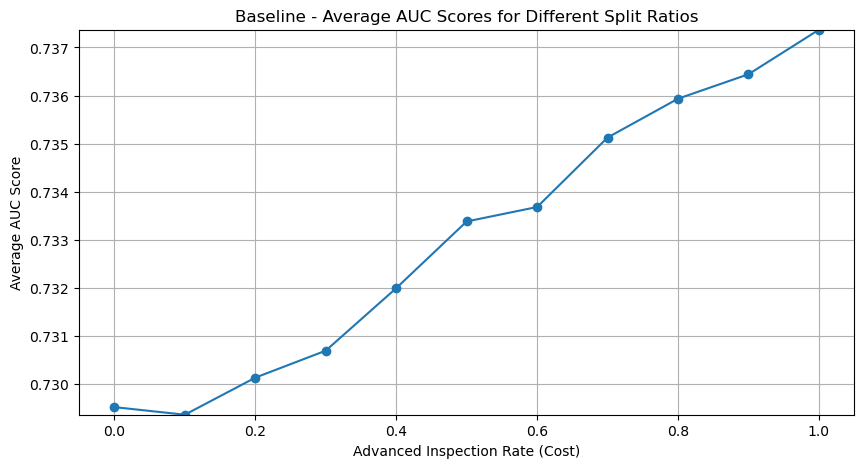

In [11]:
import torch 
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
import warnings 
warnings.filterwarnings('ignore') 
from scipy import io
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import random 
import os 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset,DataLoader

# 설치된 모듈 경로로 이동하기

%cd /home/iai/heo/recipe1_total_new_MinMaxscaler/pytorch_module

# 모듈 함수 불러오기

from split_and_predict_randomsampling import split_and_predict
from seed_everything import seed_everything
from train_teacher import train_teacher
from train_kdstudent import train_kdstudent
from train_student import train_student
from test_predict import test_predict

#---------------------------------------------------------------------------------------------------------------------------------------------------------------

# Define the range of random states

random_states = range(1, 31)

# Advance inspection ratio 정의
split_ratios = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

# 데이터 업로드

# 데이터 업로드

df = pd.read_csv('/home/iai/heo/recipe2/activeinspection_recipe2.csv')
X=df.iloc[:,3:-1].values
Y=df.iloc[:,-1].values
data_X = pd.DataFrame(X)
data_Y = pd.DataFrame(Y)
data_Y = data_Y.rename(columns={0: '0.1'})

# 난수 고정

seed_everything(42)

# loss function - crossentropy()함수

a=986/(244020+986)
b=244020/(244020+986)
weights=[a,b]
weights=torch.FloatTensor(weights)

criterion = nn.CrossEntropyLoss(weights)


# advance model(teacher model)에 사용될 feature

teacher_model_features=len(list(data_X.columns)) # 99

# advance model(teacher model) 정의하기

class Teacher(nn.Module):
    def __init__(self):
        super(Teacher, self).__init__()
        self.classifier=nn.Sequential(
            nn.Linear(in_features=teacher_model_features,out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10,out_features=2)
        )
    def forward(self, x):
        output=self.classifier(x)
        return output


# student model(basic model)에서 사용될 feature

test_stage_features=[0,1,2,3,4,5,6,7]
student_model_features=len(test_stage_features)
class Student(nn.Module):
    def __init__(self):
        super(Student, self).__init__()
        self.classifier=nn.Sequential(
            nn.Linear(in_features=8,out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10,out_features=2),
        )
    def forward(self, x):
        output=self.classifier(x)
        return output  


# 하이퍼파라미터 세팅

learning_rate = 0.01
num_epochs = 200

auc_score30_split_KD_t1=[]
auc_score30_split_KD_0_2_t1=[]
auc_score30_split_ad_KD_t1=[]

random_states=range(1, 31)
auc_scores_KD_randomsampling_t1 = np.zeros((len(random_states), len(split_ratios)))
# 30회 반복 실험
for i,random_state in enumerate(random_states):

    # 데이터 분할
    
    train_X, test_X, train_y, test_y = train_test_split(data_X, data_Y, test_size=0.5, random_state=random_state, shuffle=True, stratify=data_Y)
    train_X, val_X, train_y, val_y=train_test_split(train_X,train_y,test_size=1/5, random_state=random_state,shuffle=True, stratify=train_y)
    
    # 데이터 정규화
    
    scaler = MinMaxScaler()
    train_X_scaled = scaler.fit_transform(train_X)
    val_X_scaled=scaler.transform(val_X)
    test_X_scaled = scaler.transform(test_X)
    
    # 데이터들을 파이토치 텐서로 변환 

    train_X_tensor=torch.tensor(train_X_scaled,dtype=torch.float32)
    train_y_tensor=torch.tensor(np.array(train_y),dtype=torch.long)
    val_X_tensor=torch.tensor(val_X_scaled, dtype=torch.float32)
    val_y_tensor=torch.tensor(np.array(val_y),dtype=torch.long)
    test_X_tensor=torch.tensor(test_X_scaled,dtype=torch.float32)
    test_y_tensor=torch.tensor(np.array(test_y),dtype=torch.long)
    
    train_tensorboard=TensorDataset(train_X_tensor,train_y_tensor)
    val_tensorboard=TensorDataset(val_X_tensor,val_y_tensor)
    test_tensorboard=TensorDataset(test_X_tensor,test_y_tensor)
    
    # 배치사이즈의 크기는 학습 데이터셋의 절반 크기로 함
     
    batch_size=4900
    
    # 데이터 로더 만들어주기
    
    train_loader=DataLoader(train_tensorboard,batch_size=batch_size,shuffle=True,drop_last=True)
    val_loader=DataLoader(val_tensorboard,batch_size=batch_size,shuffle=False)
    test_loader=DataLoader(test_tensorboard,batch_size=batch_size,shuffle=False)
    # student model(basic model) 정의    
    student_model = Student()
    optimizer_KD_t1= optim.Adam(student_model.parameters(), lr=learning_rate)
    best_teacher_model=torch.load('/home/iai/heo/recipe2_total_module_MinMaxScaler/pytorch/advance_model_recipe2/advancemodel_randomstate{}'.format(i))  
        
    best_student_model=train_kdstudent(best_teacher_model,student_model,optimizer_KD_t1,criterion,train_loader,val_loader,num_epochs,temperature=1,alpha=0.5)
    torch.save(best_student_model,'/home/iai/heo/recipe2_total_module_MinMaxScaler/pytorch/temperature1_kd_model_recipe2/temperature1_kd_basicmodel_randomstate{}'.format(i))
    best_student_model=torch.load('/home/iai/heo/recipe2_total_module_MinMaxScaler/pytorch/temperature1_kd_model_recipe2/temperature1_kd_basicmodel_randomstate{}'.format(i))
    
    y_predictions=test_predict(best_student_model,"best_student_model",test_loader)

    # 테스트 데이터의 입력(X)와 라벨(y)을 결합
    
    test_data=pd.concat([test_X,test_y],axis=1)            
    
    # 예측값을 test_X DataFrame에 추가

    test_data['predictions']=y_predictions 
     
    # test_data에서 라벨을 추출
    test_y=test_data['0.1']   
    # split_ratios에 대해 반복
    for j, split_ratio in enumerate(split_ratios):
        # 주어진 분할 비율에 따른 AUC를 계산
        auc_score = split_and_predict(test_data, best_teacher_model, test_y, split_ratio,scaler,batch_size,random_state)
        # 결과 AUC를 저장
        auc_scores_KD_randomsampling_t1 [i, j] = auc_score
        # 분할 비율이 0일 때의 결과 출력 (Basic 모델)
        if split_ratio==0:
            auc_score30_split_KD_t1.append(auc_score)
            print("Random State가 ",i+1," 일 때 ", "T=1일 때 KD model: ",auc_score)
        if split_ratio==0.2:
            auc_score30_split_KD_0_2_t1.append(auc_score)
            print("Split_ratio: ",split_ratio, "이고 Random State가 ",i+1," 일 때 ", "model split ratio 0.2: ",auc_score)
        # 분할 비율이 1일 때의 결과 출력 (Advance 모델)
        if split_ratio==1:
            auc_score30_split_ad_KD_t1.append(auc_score)
            print("Random State가 ", i+1," 일 때 ","Advance model: ",auc_score)

# Calculate the average AUC scores
average_auc_scores_KD_randomsampling_t1 = auc_scores_KD_randomsampling_t1 .mean(axis=0)   


plt.figure(figsize=(10, 5))
plt.plot(split_ratios, average_auc_scores_KD_randomsampling_t1, marker='o')
plt.title('Temperature 1 - Average AUC Scores for Different Split Ratios')
plt.xlabel('Advanced Inspection Rate (Cost)')
plt.ylabel('Average AUC Score')
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
plt.ylim(min(average_auc_scores_KD_randomsampling_t1), max(average_auc_scores_KD_randomsampling_t1))
plt.grid()
plt.show()       
    
    

In [12]:
average_auc_scores_KD_randomsampling_t1

array([0.72951437, 0.72935612, 0.73012762, 0.73068927, 0.73199023,
       0.73337861, 0.73367928, 0.73512524, 0.73593379, 0.73644266,
       0.73736964])

In [13]:
print('T가 1일때 KD 모델의 AUC 평균값: ', np.mean(np.array(auc_score30_split_KD_t1)))
print('T가 1일때 KD 모델의 AUC 평균값: ', np.std(np.array(auc_score30_split_KD_t1)))

T가 1일때 KD 모델의 AUC 평균값:  0.7295143735378101
T가 1일때 KD 모델의 AUC 평균값:  0.00988048796635408


### RandomSampling Knowledge distillation(T=2) 

/home/iai/heo/recipe1_total_new_MinMaxscaler/pytorch_module


KD Basic model Early stopping
Random State가  1  일 때  T=2일 때 KD model:  0.7250591221116613
Split_ratio:  0.2 이고 Random State가  1  일 때  model split ratio 0.2:  0.7271041195871785
Random State가  1  일 때  Advance model:  0.7434110910670875
KD Basic model Early stopping
Random State가  2  일 때  T=2일 때 KD model:  0.7292882919682206
Split_ratio:  0.2 이고 Random State가  2  일 때  model split ratio 0.2:  0.7361984843792108
Random State가  2  일 때  Advance model:  0.7436141885088061
KD Basic model Early stopping
Random State가  3  일 때  T=2일 때 KD model:  0.7365877634809636
Split_ratio:  0.2 이고 Random State가  3  일 때  model split ratio 0.2:  0.7360674223989554
Random State가  3  일 때  Advance model:  0.7394576193585036
KD Basic model Early stopping
Random State가  4  일 때  T=2일 때 KD model:  0.7151410460320398
Split_ratio:  0.2 이고 Random State가  4  일 때  model split ratio 0.2:  0.72180122568346
Random State가  4  일 때  Advance model:  0.7094461881137997
Random State가  5  일 때  T=2일 때 KD model:  0.7300399096073826
Sp

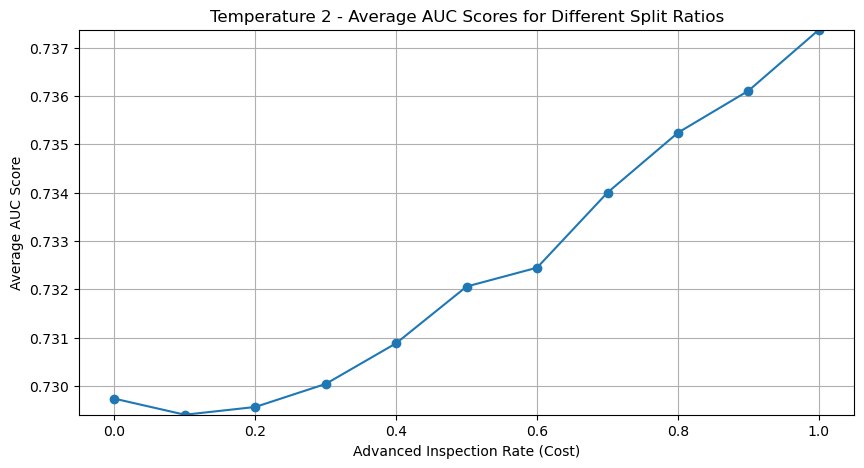

In [14]:
import torch 
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
import warnings 
warnings.filterwarnings('ignore') 
from scipy import io
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import random 
import os 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset,DataLoader

# 설치된 모듈 경로로 이동하기

%cd /home/iai/heo/recipe1_total_new_MinMaxscaler/pytorch_module

# 모듈 함수 불러오기

from split_and_predict_randomsampling import split_and_predict
from seed_everything import seed_everything
from train_teacher import train_teacher
from train_kdstudent import train_kdstudent
from train_student import train_student
from test_predict import test_predict

#---------------------------------------------------------------------------------------------------------------------------------------------------------------

# Define the range of random states

random_states = range(1, 31)

# Advance inspection ratio 정의
split_ratios = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]


# 데이터 업로드

df = pd.read_csv('/home/iai/heo/recipe2/activeinspection_recipe2.csv')
X=df.iloc[:,3:-1].values
Y=df.iloc[:,-1].values
data_X = pd.DataFrame(X)
data_Y = pd.DataFrame(Y)
data_Y = data_Y.rename(columns={0: '0.1'})

# 난수 고정

seed_everything(42)

# loss function - crossentropy()함수

a=986/(244020+986)
b=244020/(244020+986)
weights=[a,b]
weights=torch.FloatTensor(weights)

criterion = nn.CrossEntropyLoss(weights)

# advance model(teacher model)에 사용될 feature

teacher_model_features=len(list(data_X.columns)) # 99

# advance model(teacher model) 정의하기

class Teacher(nn.Module):
    def __init__(self):
        super(Teacher, self).__init__()
        self.classifier=nn.Sequential(
            nn.Linear(in_features=teacher_model_features,out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10,out_features=2)
        )
    def forward(self, x):
        output=self.classifier(x)
        return output



# student model(basic model)에서 사용될 feature

test_stage_features=[0,1,2,3,4,5,6,7]
student_model_features=len(test_stage_features)
class Student(nn.Module):
    def __init__(self):
        super(Student, self).__init__()
        self.classifier=nn.Sequential(
            nn.Linear(in_features=8,out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10,out_features=2),
        )
    def forward(self, x):
        output=self.classifier(x)
        return output  


# 하이퍼파라미터 세팅

learning_rate = 0.01
num_epochs = 200

auc_score30_split_KD_t2=[]
auc_score30_split_KD_0_2_t2=[]
auc_score30_split_ad_KD_t2=[]

random_states=range(1, 31)
auc_scores_KD_randomsampling_t2 = np.zeros((len(random_states), len(split_ratios)))
# 30회 반복 실험
for i,random_state in enumerate(random_states):

    # 데이터 분할
    
    train_X, test_X, train_y, test_y = train_test_split(data_X, data_Y, test_size=0.5, random_state=random_state, shuffle=True, stratify=data_Y)
    train_X, val_X, train_y, val_y=train_test_split(train_X,train_y,test_size=1/5, random_state=random_state,shuffle=True, stratify=train_y)
    
    # 데이터 정규화
    
    scaler = MinMaxScaler()
    train_X_scaled = scaler.fit_transform(train_X)
    val_X_scaled=scaler.transform(val_X)
    test_X_scaled = scaler.transform(test_X)
    
    # 데이터들을 파이토치 텐서로 변환 

    train_X_tensor=torch.tensor(train_X_scaled,dtype=torch.float32)
    train_y_tensor=torch.tensor(np.array(train_y),dtype=torch.long)
    val_X_tensor=torch.tensor(val_X_scaled, dtype=torch.float32)
    val_y_tensor=torch.tensor(np.array(val_y),dtype=torch.long)
    test_X_tensor=torch.tensor(test_X_scaled,dtype=torch.float32)
    test_y_tensor=torch.tensor(np.array(test_y),dtype=torch.long)
    
    train_tensorboard=TensorDataset(train_X_tensor,train_y_tensor)
    val_tensorboard=TensorDataset(val_X_tensor,val_y_tensor)
    test_tensorboard=TensorDataset(test_X_tensor,test_y_tensor)
    
    # 배치사이즈의 크기는 학습 데이터셋의 절반 크기로 함
     
    batch_size=4900
    
    # 데이터 로더 만들어주기
    
    train_loader=DataLoader(train_tensorboard,batch_size=batch_size,shuffle=True,drop_last=True)
    val_loader=DataLoader(val_tensorboard,batch_size=batch_size,shuffle=False)
    test_loader=DataLoader(test_tensorboard,batch_size=batch_size,shuffle=False)
    # student model(basic model) 초기화    
    student_model = Student()
    optimizer_KD_t2= optim.Adam(student_model.parameters(), lr=learning_rate)
    best_teacher_model=torch.load('/home/iai/heo/recipe2_total_module_MinMaxScaler/pytorch/advance_model_recipe2/advancemodel_randomstate{}'.format(i))
        
    best_student_model=train_kdstudent(best_teacher_model,student_model,optimizer_KD_t2,criterion,train_loader,val_loader,num_epochs,temperature=2,alpha=0.5)
    torch.save(best_student_model,'/home/iai/heo/recipe2_total_module_MinMaxScaler/pytorch/temperature2_kd_model_recipe2/temperature2_kd_basicmodel_randomstate{}'.format(i))
    best_student_model=torch.load('/home/iai/heo/recipe2_total_module_MinMaxScaler/pytorch/temperature2_kd_model_recipe2/temperature2_kd_basicmodel_randomstate{}'.format(i))
    
    y_predictions=test_predict(best_student_model,"best_student_model",test_loader)

    # 테스트 데이터의 입력(X)와 라벨(y)을 결합
    
    test_data=pd.concat([test_X,test_y],axis=1)            
    
    # 예측값을 test_X DataFrame에 추가

    test_data['predictions']=y_predictions 
     
    # test_data에서 라벨을 추출
    test_y=test_data['0.1']   
    # split_ratios에 대해 반복
    for j, split_ratio in enumerate(split_ratios):
        # 주어진 분할 비율에 따른 AUC를 계산
        auc_score = split_and_predict(test_data, best_teacher_model, test_y, split_ratio,scaler,batch_size,random_state)
        # 결과 AUC를 저장
        auc_scores_KD_randomsampling_t2[i, j] = auc_score
        # 분할 비율이 0일 때의 결과 출력 (Basic 모델)
        if split_ratio==0:
            auc_score30_split_KD_t2.append(auc_score)
            print("Random State가 ",i+1," 일 때 ", "T=2일 때 KD model: ",auc_score)
        if split_ratio==0.2:
            auc_score30_split_KD_0_2_t2.append(auc_score)
            print("Split_ratio: ",split_ratio, "이고 Random State가 ",i+1," 일 때 ", "model split ratio 0.2: ",auc_score)
        # 분할 비율이 1일 때의 결과 출력 (Advance 모델)
        if split_ratio==1:
            auc_score30_split_ad_KD_t2.append(auc_score)
            print("Random State가 ", i+1," 일 때 ","Advance model: ",auc_score)

# Calculate the average AUC scores
average_auc_scores_KD_randomsampling_t2 = auc_scores_KD_randomsampling_t2 .mean(axis=0)   


plt.figure(figsize=(10, 5))
plt.plot(split_ratios, average_auc_scores_KD_randomsampling_t2, marker='o')
plt.title('Temperature 2 - Average AUC Scores for Different Split Ratios')
plt.xlabel('Advanced Inspection Rate (Cost)')
plt.ylabel('Average AUC Score')
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
plt.ylim(min(average_auc_scores_KD_randomsampling_t2), max(average_auc_scores_KD_randomsampling_t2))
plt.grid()
plt.show()       
    
    

In [15]:
average_auc_scores_KD_randomsampling_t2

array([0.72974015, 0.72940775, 0.72956798, 0.73004517, 0.73088654,
       0.73205903, 0.73244908, 0.73400296, 0.73524088, 0.73610793,
       0.73736964])

### RandomSampling Knowledge distillation(T=5) 

/home/iai/heo/recipe1_total_new_MinMaxscaler/pytorch_module


KD Basic model Early stopping
Random State가  1  일 때  T=5일 때 KD model:  0.7248257009492621
Split_ratio:  0.2 이고 Random State가  1  일 때  model split ratio 0.2:  0.726918952042803
Random State가  1  일 때  Advance model:  0.7434110910670875
KD Basic model Early stopping
Random State가  2  일 때  T=5일 때 KD model:  0.7301743796812452
Split_ratio:  0.2 이고 Random State가  2  일 때  model split ratio 0.2:  0.7369887215376387
Random State가  2  일 때  Advance model:  0.7436141885088061
Random State가  3  일 때  T=5일 때 KD model:  0.7383442450515728
Split_ratio:  0.2 이고 Random State가  3  일 때  model split ratio 0.2:  0.7393129915032071
Random State가  3  일 때  Advance model:  0.7394576193585036
KD Basic model Early stopping
Random State가  4  일 때  T=5일 때 KD model:  0.7179057165034689
Split_ratio:  0.2 이고 Random State가  4  일 때  model split ratio 0.2:  0.7218743750096632
Random State가  4  일 때  Advance model:  0.7094461881137997
Random State가  5  일 때  T=5일 때 KD model:  0.7319071375953788
Split_ratio:  0.2 이고 Random Sta

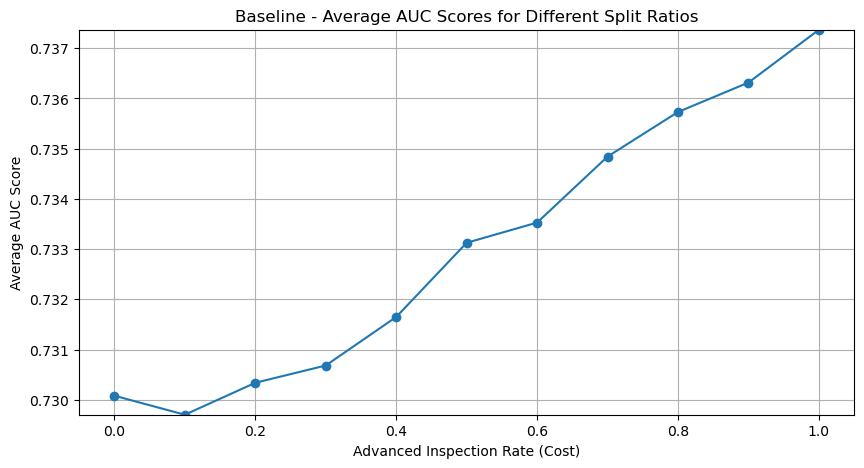

In [16]:
import torch 
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
import warnings 
warnings.filterwarnings('ignore') 
from scipy import io
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import random 
import os 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset,DataLoader

# 설치된 모듈 경로로 이동하기

%cd /home/iai/heo/recipe1_total_new_MinMaxscaler/pytorch_module

# 모듈 함수 불러오기

from split_and_predict_randomsampling import split_and_predict
from seed_everything import seed_everything
from train_teacher import train_teacher
from train_kdstudent import train_kdstudent
from train_student import train_student
from test_predict import test_predict

#---------------------------------------------------------------------------------------------------------------------------------------------------------------

# Define the range of random states

random_states = range(1, 31)

# Advance inspection ratio 정의
split_ratios = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

# 데이터 업로드

df = pd.read_csv('/home/iai/heo/recipe2/activeinspection_recipe2.csv')
X=df.iloc[:,3:-1].values
Y=df.iloc[:,-1].values
data_X = pd.DataFrame(X)
data_Y = pd.DataFrame(Y)
data_Y = data_Y.rename(columns={0: '0.1'})


# 난수 고정

seed_everything(42)

# loss function - crossentropy()함수

a=986/(244020+986)
b=244020/(244020+986)
weights=[a,b]
weights=torch.FloatTensor(weights)

criterion = nn.CrossEntropyLoss(weights)

# advance model(teacher model)에 사용될 feature

teacher_model_features=len(list(data_X.columns)) # 99

# advance model(teacher model) 정의하기

class Teacher(nn.Module):
    def __init__(self):
        super(Teacher, self).__init__()
        self.classifier=nn.Sequential(
            nn.Linear(in_features=teacher_model_features,out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10,out_features=2)
        )
    def forward(self, x):
        output=self.classifier(x)
        return output



# student model(basic model)에서 사용될 feature

test_stage_features=[0,1,2,3,4,5,6,7]
student_model_features=len(test_stage_features)
class Student(nn.Module):
    def __init__(self):
        super(Student, self).__init__()
        self.classifier=nn.Sequential(
            nn.Linear(in_features=8,out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10,out_features=2),
        )
    def forward(self, x):
        output=self.classifier(x)
        return output  


# 하이퍼파라미터 세팅

learning_rate = 0.01
num_epochs = 200

auc_score30_split_KD_t5=[]
auc_score30_split_KD_0_2_t5=[]
auc_score30_split_ad_KD_t5=[]

random_states=range(1, 31)
auc_scores_KD_randomsampling_t5 = np.zeros((len(random_states), len(split_ratios)))
# 30회 반복 실험
for i,random_state in enumerate(random_states):

    # 데이터 분할
    
    train_X, test_X, train_y, test_y = train_test_split(data_X, data_Y, test_size=0.5, random_state=random_state, shuffle=True, stratify=data_Y)
    train_X, val_X, train_y, val_y=train_test_split(train_X,train_y,test_size=1/5, random_state=random_state,shuffle=True, stratify=train_y)
    
    # 데이터 정규화
    
    scaler = MinMaxScaler()
    train_X_scaled = scaler.fit_transform(train_X)
    val_X_scaled=scaler.transform(val_X)
    test_X_scaled = scaler.transform(test_X)
    
    # 데이터들을 파이토치 텐서로 변환 

    train_X_tensor=torch.tensor(train_X_scaled,dtype=torch.float32)
    train_y_tensor=torch.tensor(np.array(train_y),dtype=torch.long)
    val_X_tensor=torch.tensor(val_X_scaled, dtype=torch.float32)
    val_y_tensor=torch.tensor(np.array(val_y),dtype=torch.long)
    test_X_tensor=torch.tensor(test_X_scaled,dtype=torch.float32)
    test_y_tensor=torch.tensor(np.array(test_y),dtype=torch.long)
    
    train_tensorboard=TensorDataset(train_X_tensor,train_y_tensor)
    val_tensorboard=TensorDataset(val_X_tensor,val_y_tensor)
    test_tensorboard=TensorDataset(test_X_tensor,test_y_tensor)
    
    # 배치사이즈의 크기는 학습 데이터셋의 절반 크기로 함
     
    batch_size=4900
    
    # 데이터 로더 만들어주기
    
    train_loader=DataLoader(train_tensorboard,batch_size=batch_size,shuffle=True,drop_last=True)
    val_loader=DataLoader(val_tensorboard,batch_size=batch_size,shuffle=False)
    test_loader=DataLoader(test_tensorboard,batch_size=batch_size,shuffle=False)
    # student model(basic model) 초기화    
    student_model = Student()
    optimizer_KD_t5= optim.Adam(student_model.parameters(), lr=learning_rate)
    best_teacher_model=torch.load('/home/iai/heo/recipe2_total_module_MinMaxScaler/pytorch/advance_model_recipe2/advancemodel_randomstate{}'.format(i))
        
    best_student_model=train_kdstudent(best_teacher_model,student_model,optimizer_KD_t5,criterion,train_loader,val_loader,num_epochs,temperature=5,alpha=0.5)
    torch.save(best_student_model,'/home/iai/heo/recipe2_total_module_MinMaxScaler/pytorch/temperature5_kd_model_recipe2/temperature5_kd_basicmodel_randomstate{}'.format(i))
    best_student_model=torch.load('/home/iai/heo/recipe2_total_module_MinMaxScaler/pytorch/temperature5_kd_model_recipe2/temperature5_kd_basicmodel_randomstate{}'.format(i))
    
    y_predictions=test_predict(best_student_model,"best_student_model",test_loader)

    # 테스트 데이터의 입력(X)와 라벨(y)을 결합
    
    test_data=pd.concat([test_X,test_y],axis=1)            
    
    # 예측값을 test_X DataFrame에 추가

    test_data['predictions']=y_predictions 
     
    # test_data에서 라벨을 추출
    test_y=test_data['0.1']   
    # split_ratios에 대해 반복
    for j, split_ratio in enumerate(split_ratios):
        # 주어진 분할 비율에 따른 AUC를 계산
        auc_score = split_and_predict(test_data, best_teacher_model, test_y, split_ratio,scaler,batch_size,random_state)
        # 결과 AUC를 저장
        auc_scores_KD_randomsampling_t5[i, j] = auc_score
        # 분할 비율이 0일 때의 결과 출력 (Basic 모델)
        if split_ratio==0:
            auc_score30_split_KD_t5.append(auc_score)
            print("Random State가 ",i+1," 일 때 ", "T=5일 때 KD model: ",auc_score)
        if split_ratio==0.2:
            auc_score30_split_KD_0_2_t5.append(auc_score)
            print("Split_ratio: ",split_ratio, "이고 Random State가 ",i+1," 일 때 ", "model split ratio 0.2: ",auc_score)
        # 분할 비율이 1일 때의 결과 출력 (Advance 모델)
        if split_ratio==1:
            auc_score30_split_ad_KD_t5.append(auc_score)
            print("Random State가 ", i+1," 일 때 ","Advance model: ",auc_score)

# Calculate the average AUC scores
average_auc_scores_KD_randomsampling_t5 = auc_scores_KD_randomsampling_t5.mean(axis=0)   


plt.figure(figsize=(10, 5))
plt.plot(split_ratios, average_auc_scores_KD_randomsampling_t5, marker='o')
plt.title('Baseline - Average AUC Scores for Different Split Ratios')
plt.xlabel('Advanced Inspection Rate (Cost)')
plt.ylabel('Average AUC Score')
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
plt.ylim(min(average_auc_scores_KD_randomsampling_t5), max(average_auc_scores_KD_randomsampling_t5))
plt.grid()
plt.show()       
    
    

In [17]:
average_auc_scores_KD_randomsampling_t5

array([0.7300797 , 0.72970138, 0.73033765, 0.73068161, 0.73164799,
       0.73312603, 0.73352809, 0.73484305, 0.7357312 , 0.73631708,
       0.73736964])

### RandomSampling Knowledge distillation(T=10) 

/home/iai/heo/recipe1_total_new_MinMaxscaler/pytorch_module


KD Basic model Early stopping
Random State가  1  일 때  T=10일 때 KD model:  0.7234432368709844
Split_ratio:  0.2 이고 Random State가  1  일 때  model split ratio 0.2:  0.7283130036393453
Random State가  1  일 때  Advance model:  0.7434110910670875
KD Basic model Early stopping
Random State가  2  일 때  T=10일 때 KD model:  0.7273509985631145
Split_ratio:  0.2 이고 Random State가  2  일 때  model split ratio 0.2:  0.7328394423826863
Random State가  2  일 때  Advance model:  0.7436141885088061
KD Basic model Early stopping
Random State가  3  일 때  T=10일 때 KD model:  0.7378856569632424
Split_ratio:  0.2 이고 Random State가  3  일 때  model split ratio 0.2:  0.7389126319410191
Random State가  3  일 때  Advance model:  0.7394576193585036
KD Basic model Early stopping
Random State가  4  일 때  T=10일 때 KD model:  0.7110829042875979
Split_ratio:  0.2 이고 Random State가  4  일 때  model split ratio 0.2:  0.719319942351681
Random State가  4  일 때  Advance model:  0.7094461881137997
Random State가  5  일 때  T=10일 때 KD model:  0.7275017859241

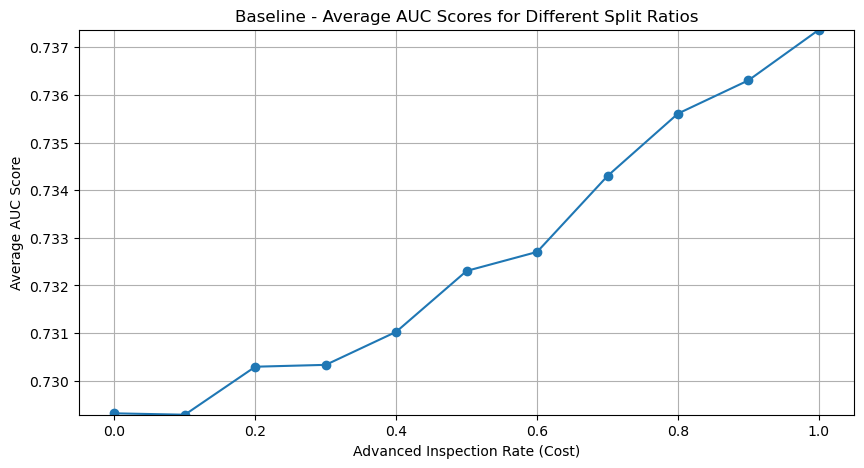

In [18]:

import torch 
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
import warnings 
warnings.filterwarnings('ignore') 
from scipy import io
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import random 
import os 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset,DataLoader


# 설치된 모듈 경로로 이동하기

%cd /home/iai/heo/recipe1_total_new_MinMaxscaler/pytorch_module

# 모듈 함수 불러오기

from split_and_predict_randomsampling import split_and_predict
from seed_everything import seed_everything
from train_teacher import train_teacher
from train_kdstudent import train_kdstudent
from train_student import train_student
from test_predict import test_predict

#---------------------------------------------------------------------------------------------------------------------------------------------------------------

# Define the range of random states

random_states = range(1, 31)

# Advance inspection ratio 정의
split_ratios = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

# 데이터 업로드

df = pd.read_csv('/home/iai/heo/recipe2/activeinspection_recipe2.csv')
X=df.iloc[:,3:-1].values
Y=df.iloc[:,-1].values
data_X = pd.DataFrame(X)
data_Y = pd.DataFrame(Y)
data_Y = data_Y.rename(columns={0: '0.1'})

# 난수 고정

seed_everything(42)

# loss function - crossentropy()함수

a=986/(244020+986)
b=244020/(244020+986)
weights=[a,b]
weights=torch.FloatTensor(weights)

criterion = nn.CrossEntropyLoss(weights)

# advance model(teacher model)에 사용될 feature

teacher_model_features=len(list(data_X.columns)) # 99

# advance model(teacher model) 정의하기

class Teacher(nn.Module):
    def __init__(self):
        super(Teacher, self).__init__()
        self.classifier=nn.Sequential(
            nn.Linear(in_features=teacher_model_features,out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10,out_features=2)
        )
    def forward(self, x):
        output=self.classifier(x)
        return output



# student model(basic model)에서 사용될 feature

test_stage_features=[0,1,2,3,4,5,6,7]
student_model_features=len(test_stage_features)
class Student(nn.Module):
    def __init__(self):
        super(Student, self).__init__()
        self.classifier=nn.Sequential(
            nn.Linear(in_features=8,out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10,out_features=2),
        )
    def forward(self, x):
        output=self.classifier(x)
        return output  


# 하이퍼파라미터 세팅

learning_rate = 0.01
num_epochs = 200

auc_score30_split_KD_t10=[]
auc_score30_split_KD_0_2_t10=[]
auc_score30_split_ad_KD_t10=[]

random_states=range(1, 31)
auc_scores_KD_randomsampling_t10 = np.zeros((len(random_states), len(split_ratios)))
# 30회 반복 실험
for i,random_state in enumerate(random_states):

    # 데이터 분할
    
    train_X, test_X, train_y, test_y = train_test_split(data_X, data_Y, test_size=0.5, random_state=random_state, shuffle=True, stratify=data_Y)
    train_X, val_X, train_y, val_y=train_test_split(train_X,train_y,test_size=1/5, random_state=random_state,shuffle=True, stratify=train_y)
    
    # 데이터 정규화
    
    scaler = MinMaxScaler()
    train_X_scaled = scaler.fit_transform(train_X)
    val_X_scaled=scaler.transform(val_X)
    test_X_scaled = scaler.transform(test_X)
    
    # 데이터들을 파이토치 텐서로 변환 

    train_X_tensor=torch.tensor(train_X_scaled,dtype=torch.float32)
    train_y_tensor=torch.tensor(np.array(train_y),dtype=torch.long)
    val_X_tensor=torch.tensor(val_X_scaled, dtype=torch.float32)
    val_y_tensor=torch.tensor(np.array(val_y),dtype=torch.long)
    test_X_tensor=torch.tensor(test_X_scaled,dtype=torch.float32)
    test_y_tensor=torch.tensor(np.array(test_y),dtype=torch.long)
    
    train_tensorboard=TensorDataset(train_X_tensor,train_y_tensor)
    val_tensorboard=TensorDataset(val_X_tensor,val_y_tensor)
    test_tensorboard=TensorDataset(test_X_tensor,test_y_tensor)
    
    # 배치사이즈의 크기는 학습 데이터셋의 절반 크기로 함
     
    batch_size=3694
    
    # 데이터 로더 만들어주기
    
    train_loader=DataLoader(train_tensorboard,batch_size=batch_size,shuffle=True,drop_last=True)
    val_loader=DataLoader(val_tensorboard,batch_size=batch_size,shuffle=False)
    test_loader=DataLoader(test_tensorboard,batch_size=batch_size,shuffle=False)
    # student model(basic model) 초기화    
    student_model = Student()
    optimizer_KD_t10= optim.Adam(student_model.parameters(), lr=learning_rate)
    best_teacher_model=torch.load('/home/iai/heo/recipe2_total_module_MinMaxScaler/pytorch/advance_model_recipe2/advancemodel_randomstate{}'.format(i))
        
    best_student_model=train_kdstudent(best_teacher_model,student_model,optimizer_KD_t10,criterion,train_loader,val_loader,num_epochs,temperature=10,alpha=0.5)
    torch.save(best_student_model,'/home/iai/heo/recipe2_total_module_MinMaxScaler/pytorch/temperature10_kd_model_recipe2/temperature10_kd_basicmodel_randomstate{}'.format(i))
    best_student_model=torch.load('/home/iai/heo/recipe2_total_module_MinMaxScaler/pytorch/temperature10_kd_model_recipe2/temperature10_kd_basicmodel_randomstate{}'.format(i))
    
    y_predictions=test_predict(best_student_model,"best_student_model",test_loader)

    # 테스트 데이터의 입력(X)와 라벨(y)을 결합
    
    test_data=pd.concat([test_X,test_y],axis=1)            
    
    # 예측값을 test_X DataFrame에 추가

    test_data['predictions']=y_predictions 
     
    # test_data에서 라벨을 추출
    test_y=test_data['0.1']   
    # split_ratios에 대해 반복
    for j, split_ratio in enumerate(split_ratios):
        # 주어진 분할 비율에 따른 AUC를 계산
        auc_score = split_and_predict(test_data, best_teacher_model, test_y, split_ratio,scaler,batch_size,random_state)
        # 결과 AUC를 저장
        auc_scores_KD_randomsampling_t10[i, j] = auc_score
        # 분할 비율이 0일 때의 결과 출력 (Basic 모델)
        if split_ratio==0:
            auc_score30_split_KD_t10.append(auc_score)
            print("Random State가 ",i+1," 일 때 ", "T=10일 때 KD model: ",auc_score)
        if split_ratio==0.2:
            auc_score30_split_KD_0_2_t10.append(auc_score)
            print("Split_ratio: ",split_ratio, "이고 Random State가 ",i+1," 일 때 ", "model split ratio 0.2: ",auc_score)
        # 분할 비율이 1일 때의 결과 출력 (Advance 모델)
        if split_ratio==1:
            auc_score30_split_ad_KD_t10.append(auc_score)
            print("Random State가 ", i+1," 일 때 ","Advance model: ",auc_score)

# Calculate the average AUC scores
average_auc_scores_KD_randomsampling_t10 = auc_scores_KD_randomsampling_t10.mean(axis=0)   


plt.figure(figsize=(10, 5))
plt.plot(split_ratios, average_auc_scores_KD_randomsampling_t10, marker='o')
plt.title('Baseline - Average AUC Scores for Different Split Ratios')
plt.xlabel('Advanced Inspection Rate (Cost)')
plt.ylabel('Average AUC Score')
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
plt.ylim(min(average_auc_scores_KD_randomsampling_t10), max(average_auc_scores_KD_randomsampling_t10))
plt.grid()
plt.show()       
    
    

In [19]:
average_auc_scores_KD_randomsampling_t10

array([0.72931338, 0.72928422, 0.73029249, 0.73033147, 0.73102531,
       0.73230435, 0.73270309, 0.73429916, 0.73560897, 0.73630717,
       0.73736964])

### Randomsampling VM

In [22]:
import torch 
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
import warnings 
warnings.filterwarnings('ignore') 
from scipy import io
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import random 
import os 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset,DataLoader

# 설치된 모듈 경로로 이동하기

%cd /home/iai/heo/recipe1_total_new_MinMaxscaler/pytorch_module

from split_and_predict_randomsampling import split_and_predict
from seed_everything import seed_everything
from virtual_features import virtual_features
from test_predict import test_predict

#---------------------------------------------------------------------------------------------------------------------------------------------------------------

# Define the range of random states

random_states = range(1, 31)

# Advance inspection ratio 정의

split_ratios = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

# 데이터 업로드

df = pd.read_csv('/home/iai/heo/recipe2/activeinspection_recipe2.csv')
X=df.iloc[:,3:-1].values
Y=df.iloc[:,-1].values
data_X = pd.DataFrame(X)
data_Y = pd.DataFrame(Y)
data_Y = data_Y.rename(columns={0: '0.1'})

# 난수 고정

seed_everything(42)

# advance model(teacher model)에 사용될 feature

teacher_model_features=len(list(data_X.columns)) # 99

# advance model(teacher model) 정의하기

class Teacher(nn.Module):
    def __init__(self):
        super(Teacher, self).__init__()
        self.classifier=nn.Sequential(
            nn.Linear(in_features=teacher_model_features,out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10,out_features=2)
        )
    def forward(self, x):
        output=self.classifier(x)
        return output



# student model(basic model)에서 사용될 feature

test_stage_features=[0,1,2,3,4,5,6,7]
student_model_features=len(test_stage_features)
class Student(nn.Module):
    def __init__(self):
        super(Student, self).__init__()
        self.classifier=nn.Sequential(
            nn.Linear(in_features=8,out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10,out_features=2),
        )
    def forward(self, x):
        output=self.classifier(x)
        return output  


# 하이퍼파라미터 세팅

learning_rate = 0.01
num_epochs = 200

auc_score30_split_VM=[]
auc_score30_split_VM_0_2=[]
auc_score30_split_ad_VM=[]

random_states=range(1, 31)
auc_scores_VM_randomsampling = np.zeros((len(random_states), len(split_ratios)))
# 30회 반복 실험
for i,random_state in enumerate(random_states):

    # 데이터 분할
    
    train_X, test_X, train_y, test_y = train_test_split(data_X, data_Y, test_size=0.5, random_state=random_state, shuffle=True, stratify=data_Y)
    train_X2, val_X, train_y2, val_y=train_test_split(train_X,train_y,test_size=1/5, random_state=random_state,shuffle=True, stratify=train_y)
    
    # 데이터 정규화
    
    scaler = MinMaxScaler()
    train_X_scaled = scaler.fit_transform(train_X2)
    val_X_scaled=scaler.transform(val_X)
    test_X_scaled = scaler.transform(test_X)
    
    # 데이터들을 파이토치 텐서로 변환 

    train_X_tensor=torch.tensor(train_X_scaled,dtype=torch.float32)
    train_y_tensor=torch.tensor(np.array(train_y2),dtype=torch.long)
    val_X_tensor=torch.tensor(val_X_scaled, dtype=torch.float32)
    val_y_tensor=torch.tensor(np.array(val_y),dtype=torch.long)
    test_X_tensor=torch.tensor(test_X_scaled,dtype=torch.float32)
    test_y_tensor=torch.tensor(np.array(test_y),dtype=torch.long)
    
    train_tensorboard=TensorDataset(train_X_tensor,train_y_tensor)
    val_tensorboard=TensorDataset(val_X_tensor,val_y_tensor)
    test_tensorboard=TensorDataset(test_X_tensor,test_y_tensor)
    
    # 배치사이즈의 크기는 학습 데이터셋의 절반 크기로 함
     
    batch_size=4900
    
    # 데이터 로더 만들어주기
    
    train_loader=DataLoader(train_tensorboard,batch_size=batch_size,shuffle=True,drop_last=True)
    val_loader=DataLoader(val_tensorboard,batch_size=batch_size,shuffle=False)
    test_loader=DataLoader(test_tensorboard,batch_size=batch_size,shuffle=False)

    best_teacher_model=torch.load('/home/iai/heo/recipe2_total_module_MinMaxScaler/pytorch/advance_model_recipe2/advancemodel_randomstate{}'.format(i))    
    
    # 가상계측 변수 만들기

    test_X_new=virtual_features(train_X,test_X,num_features=88)
    test_X_new.to_csv('/home/iai/heo/recipe2_total_module_MinMaxScaler/pytorch/vm_dataset/virtual_dataset_randomstate{}.csv'.format(i),index=False)
    # 가상계측 변수 Scaling해주기   

    test_X_new_scaled=scaler.transform(test_X_new)
    # 가상계측 변수가 포함된 VM model로 test data 예측하기
    test_X_new_tensor=torch.tensor(test_X_new_scaled,dtype=torch.float32)
    test_new_tensorboard=TensorDataset(test_X_new_tensor,test_y_tensor)
    test_new_loader=DataLoader(test_new_tensorboard,batch_size=batch_size,shuffle=False) 
       
    y_predictions=test_predict(best_teacher_model,"best_teacher_model",test_new_loader)

    test_data=pd.concat([test_X,test_y],axis=1)

    test_data['predictions']=y_predictions 


    test_y=test_data['0.1']   
    # Loop through the split_ratios
    for j, split_ratio in enumerate(split_ratios):
        auc_score = split_and_predict(test_data, best_teacher_model, test_y, split_ratio,scaler,batch_size,random_state)
        auc_scores_VM_randomsampling[i, j] = auc_score
        if split_ratio==0:
            auc_score30_split_VM.append(auc_score)
            print('Random state가 ',i+1,'일 때 , VM model: ',auc_score)
        if split_ratio==1:
            auc_score30_split_ad_VM.append(auc_score)
            print('Random state가 ',i+1,'일 때 , Advance model: ',auc_score)    
    
# Calculate the average AUC scores

average_auc_scores_VM_randomsampling = auc_scores_VM_randomsampling.mean(axis=0)   


plt.figure(figsize=(10, 5))
plt.plot(split_ratios, average_auc_scores_VM_randomsampling, marker='o')
plt.title('Baseline - Average AUC Scores for Different Split Ratios')
plt.xlabel('Advanced Inspection Rate (Cost)')
plt.ylabel('Average AUC Score')
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
plt.ylim(min(average_auc_scores_VM_randomsampling), max(average_auc_scores_VM_randomsampling))
plt.grid()
plt.show()    

/home/iai/heo/recipe1_total_25_new/pytorch_module
Random state가  1 일 때 , VM model:  0.7205499399593656
Random state가  1 일 때 , Advance model:  0.7403096926348438
Random state가  2 일 때 , VM model:  0.7340860482123883
Random state가  2 일 때 , Advance model:  0.745022562410922
Random state가  3 일 때 , VM model:  0.7352047923448565
Random state가  3 일 때 , Advance model:  0.7469993065776372
Random state가  4 일 때 , VM model:  0.7075326433024394
Random state가  4 일 때 , Advance model:  0.7209551456644145
Random state가  5 일 때 , VM model:  0.7365197179827477
Random state가  5 일 때 , Advance model:  0.741443498878571


In [ ]:
average_auc_scores_VM_randomsampling

In [22]:
average_auc_scores_Baseline_randomsampling=[0.72816782, 0.72800907, 0.72850484, 0.72884886, 0.72976809,0.73125033, 0.73165623, 0.73343749, 0.73480531, 0.73597803,0.73736964]
average_auc_scores_KD_randomsampling_t1=[0.72951437, 0.72935612, 0.73012762, 0.73068927, 0.73199023,0.73337861, 0.73367928, 0.73512524, 0.73593379, 0.73644266, 0.73736964]
average_auc_scores_KD_randomsampling_t2= [0.72974015, 0.72940775, 0.72956798, 0.73004517, 0.73088654, 0.73205903, 0.73244908, 0.73400296, 0.73524088, 0.73610793, 0.73736964]
average_auc_scores_KD_randomsampling_t5=[0.7300797 , 0.72970138, 0.73033765, 0.73068161, 0.73164799,0.73312603, 0.73352809, 0.73484305, 0.7357312 , 0.73631708, 0.73736964]
average_auc_scores_KD_randomsampling_t10=[0.72931338, 0.72928422, 0.73029249, 0.73033147, 0.73102531,0.73230435, 0.73270309, 0.73429916, 0.73560897, 0.73630717, 0.73736964]
#average_auc_scores_VM_randomsampling=[0.72959295, 0.72978887, 0.73043398, 0.7311684 , 0.7317077 , 0.73314702, 0.73393109, 0.7354653 , 0.73619821, 0.73654543, 0.73817815]

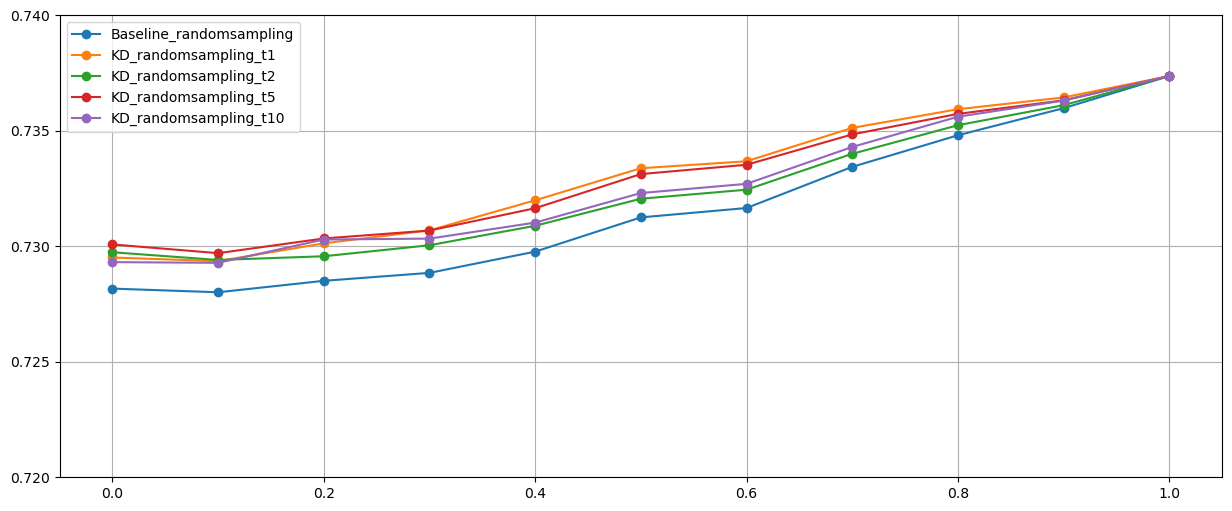

In [23]:

import matplotlib.pyplot as plt 

split_ratio=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

plt.figure(figsize=(15,6))
plt.plot(split_ratio,average_auc_scores_Baseline_randomsampling,marker='o',label='Baseline_randomsampling')
plt.plot(split_ratio,average_auc_scores_KD_randomsampling_t1,marker='o',label='KD_randomsampling_t1')
plt.plot(split_ratio,average_auc_scores_KD_randomsampling_t2,marker='o',label='KD_randomsampling_t2')
plt.plot(split_ratio,average_auc_scores_KD_randomsampling_t5,marker='o',label='KD_randomsampling_t5')
plt.plot(split_ratio,average_auc_scores_KD_randomsampling_t10,marker='o',label='KD_randomsampling_t10')
#plt.plot(split_ratio,average_auc_scores_VM_randomsampling,marker='o',label='VM_randomsampling')
plt.legend()
plt.yticks([0.720,0.725,0.73,0.735,0.740])
plt.grid()
plt.show()
